# <center>Predicting Customer Churn</center>

<img src='Customer-churn-1024x695.jpg' width="400">

This analysis attempts to predict bank customer attrition based on the number of products they hold, tenure with the bank, as well as the geographical location of the customers.


- <a href='#1'>1. Data</a>
    - <a href='#1.1'>1.1. Import Preliminary Libraries</a>
    - <a href='#1.2'>1.2. Load Data</a>
    - <a href='#1.3'>1.3. Data Overview</a>
- <a href='#2'>2. Data Cleaning and Feature engineering</a>
- <a href='#3'>3. Exploratory Data Analysis</a>
    - <a href='#3.1'>3.1. Active Member Status and Churn status</a>
    - <a href='#3.2'>3.2. Profiling Churned Clients - Average number of churned client per category</a>
    - <a href='#3.2'>3.3. Geographical Analyis of Churned and Non-churned Clients</a>
- <a href='#4'>4. Data Processing</a>
    - <a href='#4.1'>4.1. Encoding Categorical, binary and standardizing numerical variables</a>
    - <a href='#4.2'>4.2. Imbalanced dataset - resampling the target outcome</a>
- <a href='#5'>5. Data Modelling </a>
    - <a href='#5.1'>5.1. Logistic Regression Model (Baseline mode)</a>



# <a id='1'>1. Data</a>

## <a id='1.1'>1.1. Import Preliminary Libraries</a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import seaborn as sns
import requests
import math
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as mpatches

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## <a id='1.2'>1.2. Load Data</a>

In [2]:
cd /home/simphiwe/Documents/notebooks/Churn

/home/simphiwe/Documents/notebooks/Churn


In [3]:
df = pd.read_csv('Churn_Modelling.csv')

## <a id='1.3'>1.3. Data Overview</a>

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info() #List of variables and type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df.shape #row and column dimensions

(10000, 14)

#### Missing Values

In [7]:
 df.isnull().sum() 

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Unique values 

In [8]:
df.nunique() 

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

# <a id='2'>2. Data Cleaning and Feature engineering</a>

In [9]:
#Drop unnecessary columns
df=df.drop(['Surname', 'RowNumber'], axis=1)

#### Binning credit scoring

In [10]:
def credit_cat(df) :
    
    if df['CreditScore'] >= 740 :
        return 'Excellent'
    elif (df['CreditScore'] >= 670) & (df['CreditScore'] < 740 ):
        return 'Good'
    elif (df['CreditScore'] >= 580) & (df['CreditScore'] < 670) :
        return 'Fair'
    elif (df['CreditScore'] >= 300) & (df['CreditScore'] < 580) :
        return 'Poor'
      
    
df['Credit_cat'] = df.apply(lambda df:credit_cat(df), axis = 1)

In [11]:
#Ordering the categorical columns
df['Credit_cat'] = pd.Categorical(df['Credit_cat'], 
                                     categories=['Poor', 'Fair','Good', 'Excellent'], ordered=True)

##### Binning Age Category

In [12]:
def age_cat(df) :
    
    if (df['Age'] >= 18) & (df['Age'] < 25) :
        return '18-24'
    elif (df['Age'] >= 25) & (df['Age'] < 35 ):
        return '25-34'
    elif (df['Age'] >= 35) & (df['Age'] < 45) :
        return '35-44'
    elif (df['Age'] >= 45) & (df['Age'] < 55) :
        return '45-54'
    elif (df['Age'] >= 55) & (df['Age'] < 65) :
        return '55-65'
    elif (df['Age'] >=65) & (df['Age'] <= 92):
        return '65+'
    
    
df['Age_cat'] = df.apply(lambda df:age_cat(df), axis = 1)

#### Change dtypes

In [13]:
for col in ['Credit_cat', 'Geography' ]:
    df[col] = df[col].astype('category')

In [14]:
for col in ['Exited', 'IsActiveMember']:
    df[col] = df[col].astype('?')

#### Creating Income quintiles

In [15]:
df['Income_quart'] = pd.qcut(df['EstimatedSalary'], 5, labels=['Quintile 1', 'Quintile 2', 'Quintile 3', 
                                                              'Quintile 4', 'Quintile 5'])

# <a id='3'>3. Exploratory Data Analysis</a>

## <a id='3.1'>3.1. Active Member Status and Churn status</a>

In [16]:
pd.crosstab(df.IsActiveMember, df.Exited, margins=True)/len(df)*100

Exited,False,True,All
IsActiveMember,,,
False,35.47,13.02,48.49
True,44.16,7.35,51.51
All,79.63,20.37,100.00


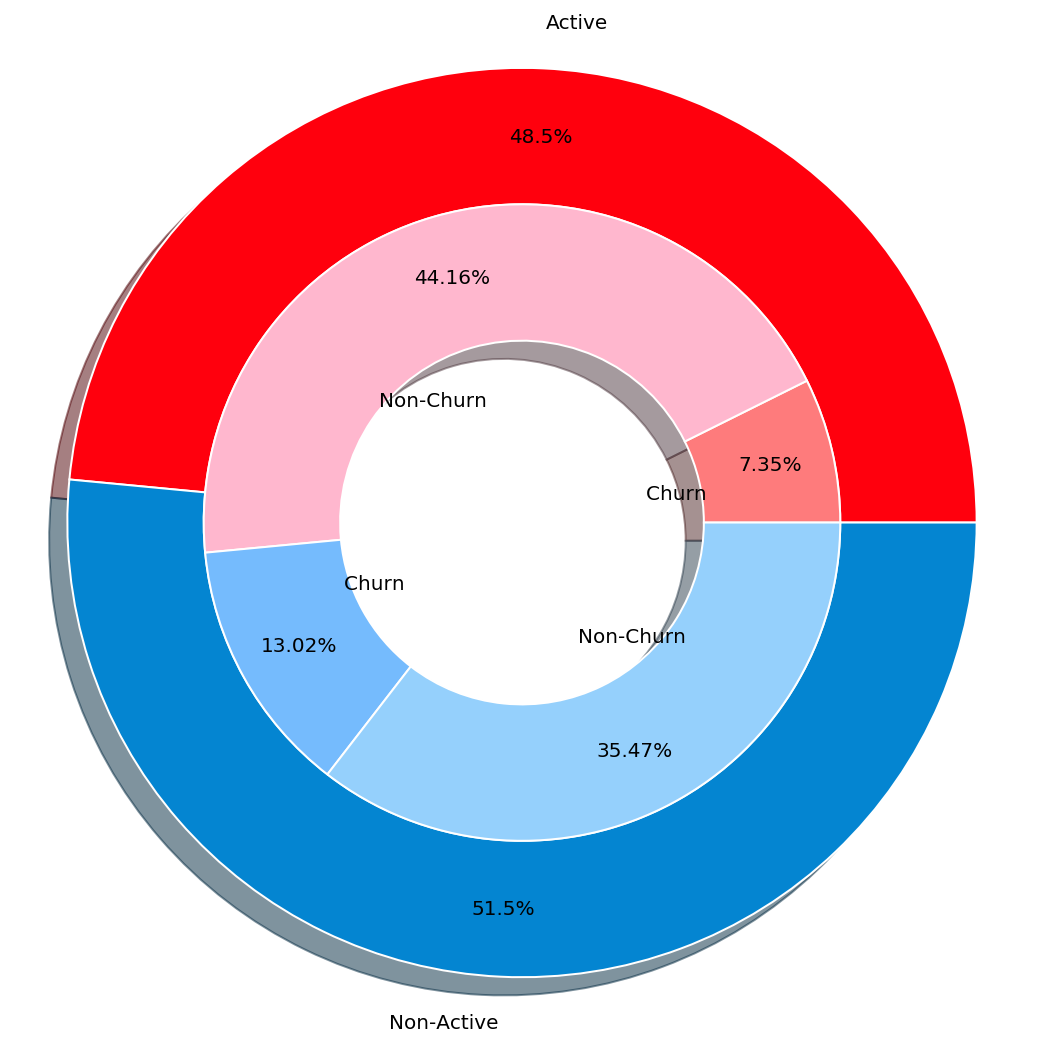

In [17]:
fig=plt.figure(figsize=[9, 9])

plt.pie([48.49, 51.51], radius=1,
        colors=['xkcd:bright red', 'xkcd:cerulean', 'xkcd:grass green'],
        labels=['Active', 'Non-Active'], autopct='%.1f%%',
        pctdistance=0.85, shadow=True,
        wedgeprops=dict(width=0.3, edgecolor='white'))

plt.pie([7.35, 44.16, 13.02, 35.47], radius=0.7,
        colors=[ 'xkcd:salmon pink', 'xkcd:baby pink', 'xkcd:sky blue', 'xkcd:light blue'],
        wedgeprops=dict(width=0.3, edgecolor='white'),
        labels=['Churn ', 'Non-Churn', 'Churn ', 'Non-Churn'], autopct='%.2f%%',
        pctdistance=0.8, labeldistance=0.4, shadow=True)
plt.axis('equal')

plt.show()

## <a id='3.2'>3.2. Profiling Churned Clients - Average number of churned client per category </a>


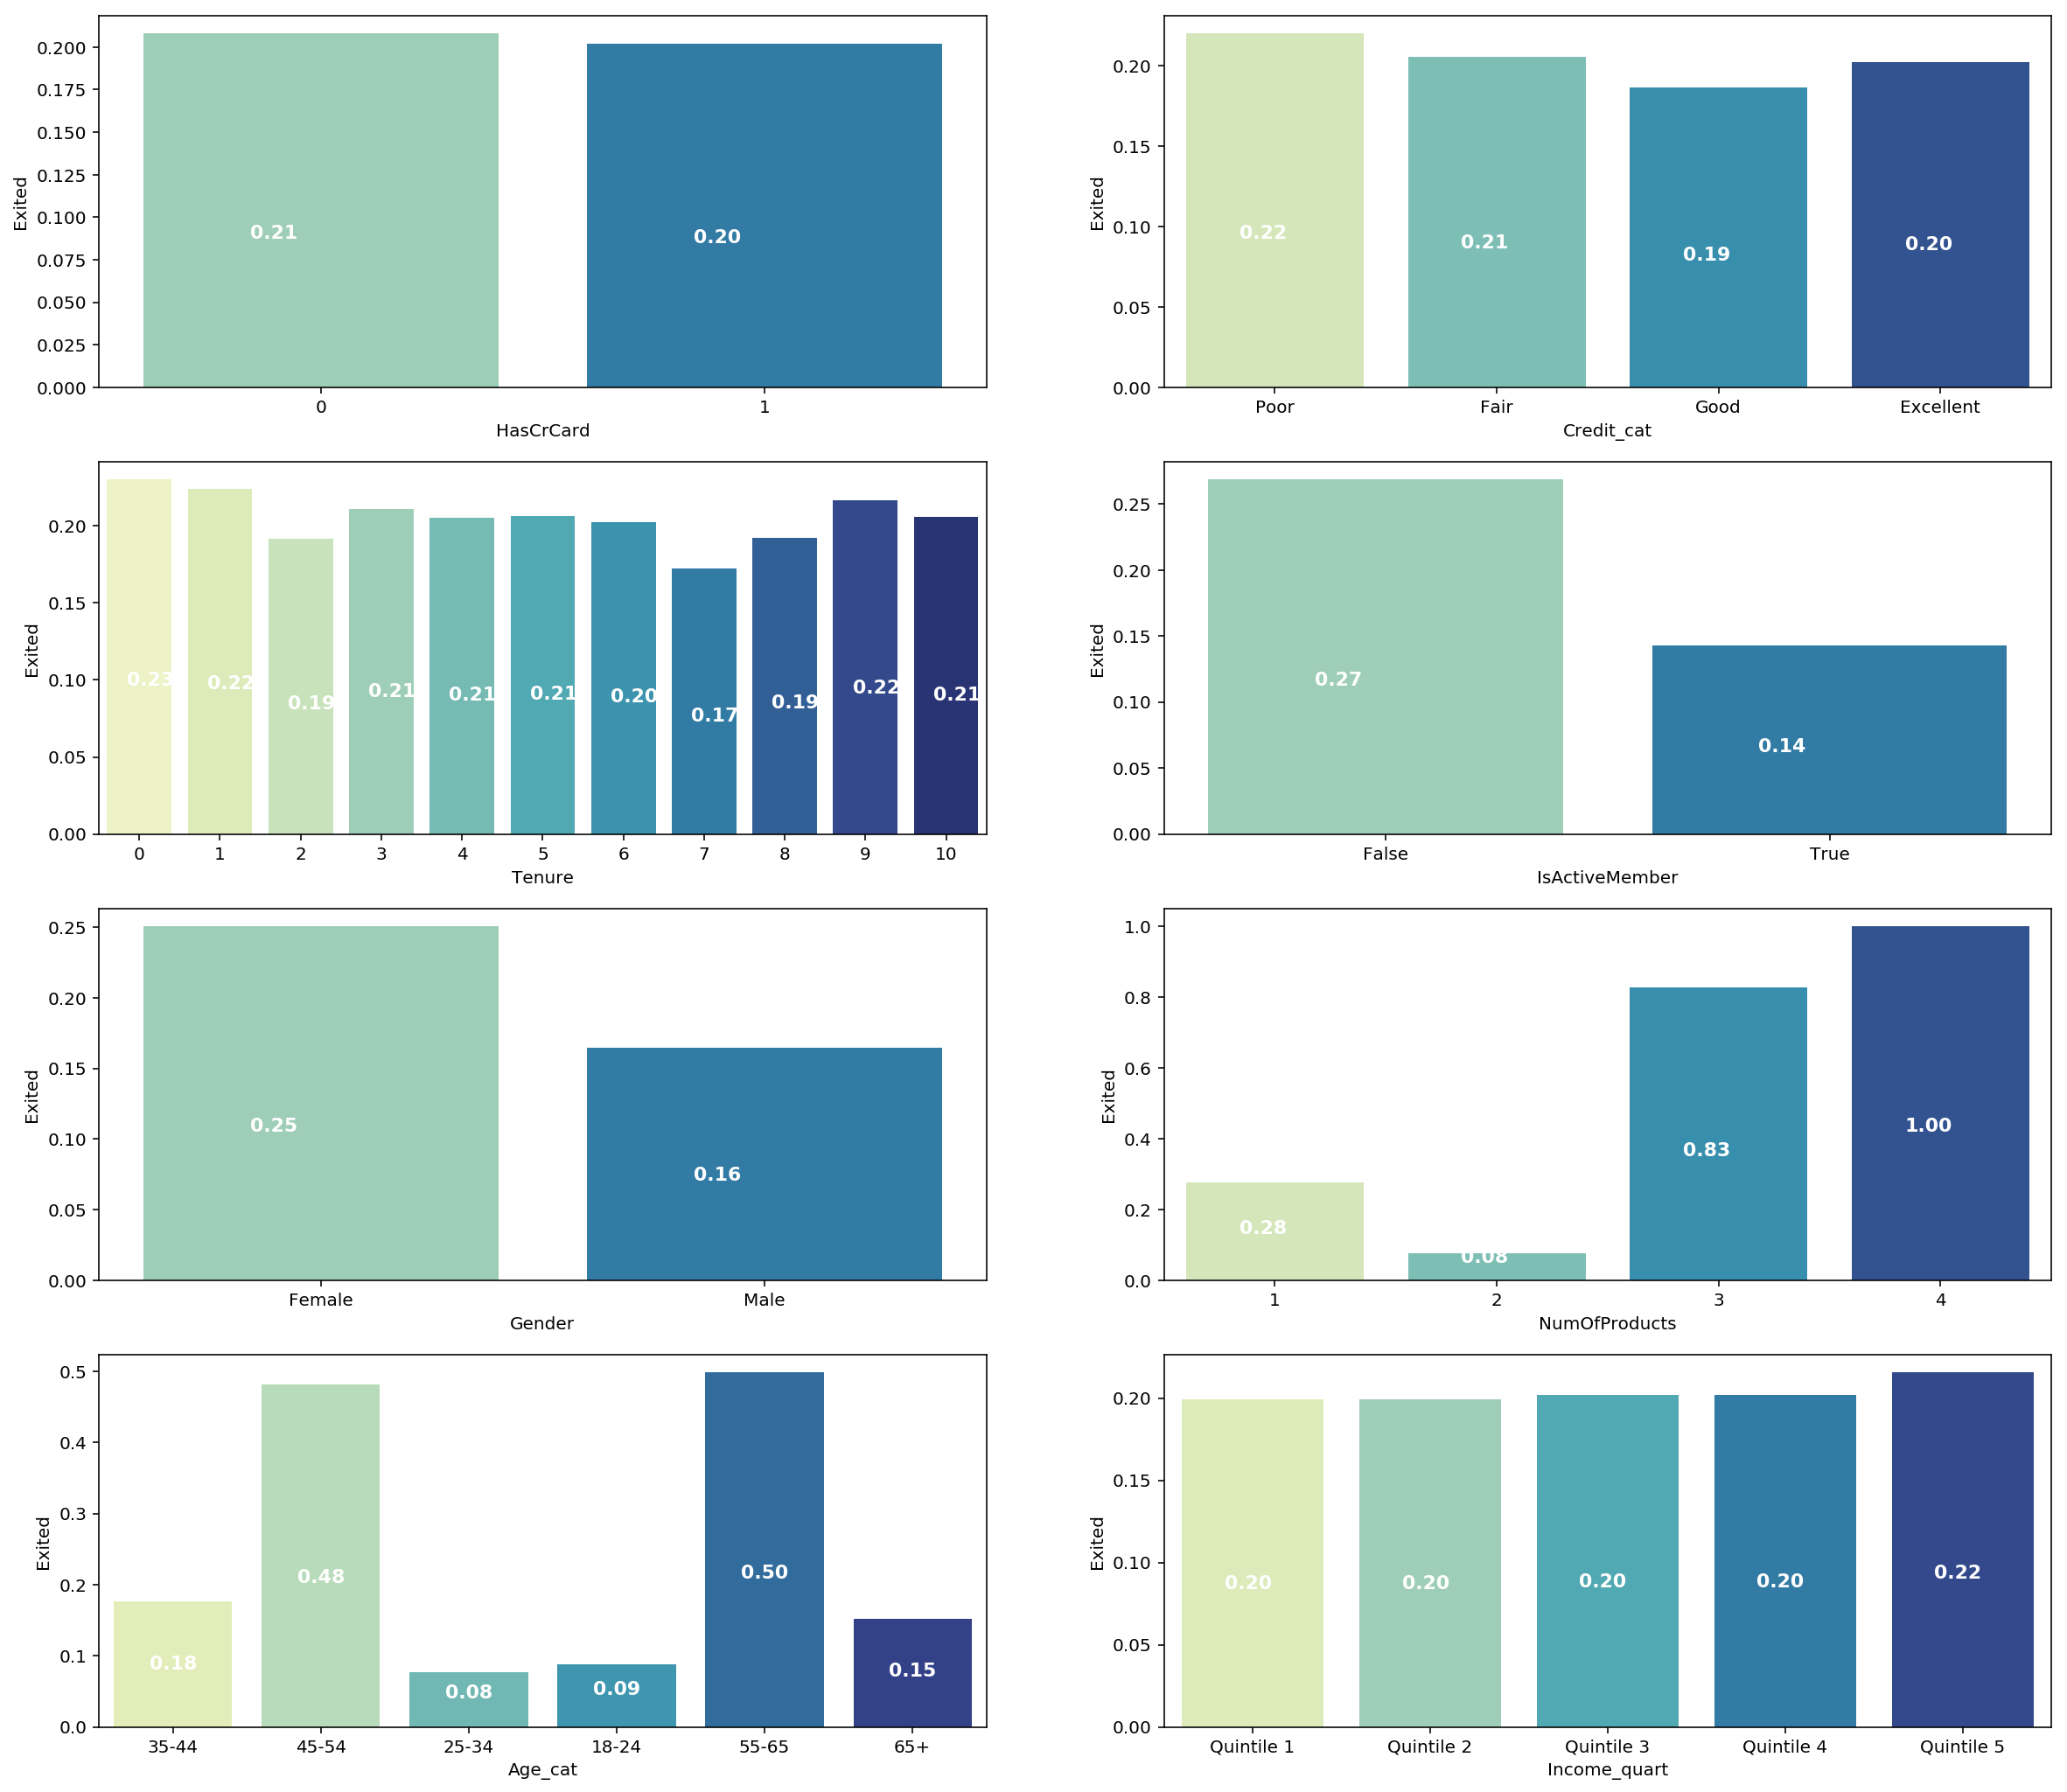

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(20, 18))

#Main graphs
for col, ax in zip(['HasCrCard', 'Credit_cat', 'Tenure', 'IsActiveMember', 'Gender',
                    'NumOfProducts', 'Age_cat', 'Income_quart'], axes.flatten()):
    sns.barplot(x=col, y='Exited', data=df, ax=ax, palette="YlGnBu", ci=None)
    #legend=ax.legend(['Churned','Non-Churned'],
                     #loc='best')

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.2f}'.format(height), (p.get_x()+.30*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold', fontsize=11)

## <a id='3.3'>3.3. Geographical Analyis of Churned and Non-churned Clients</a>

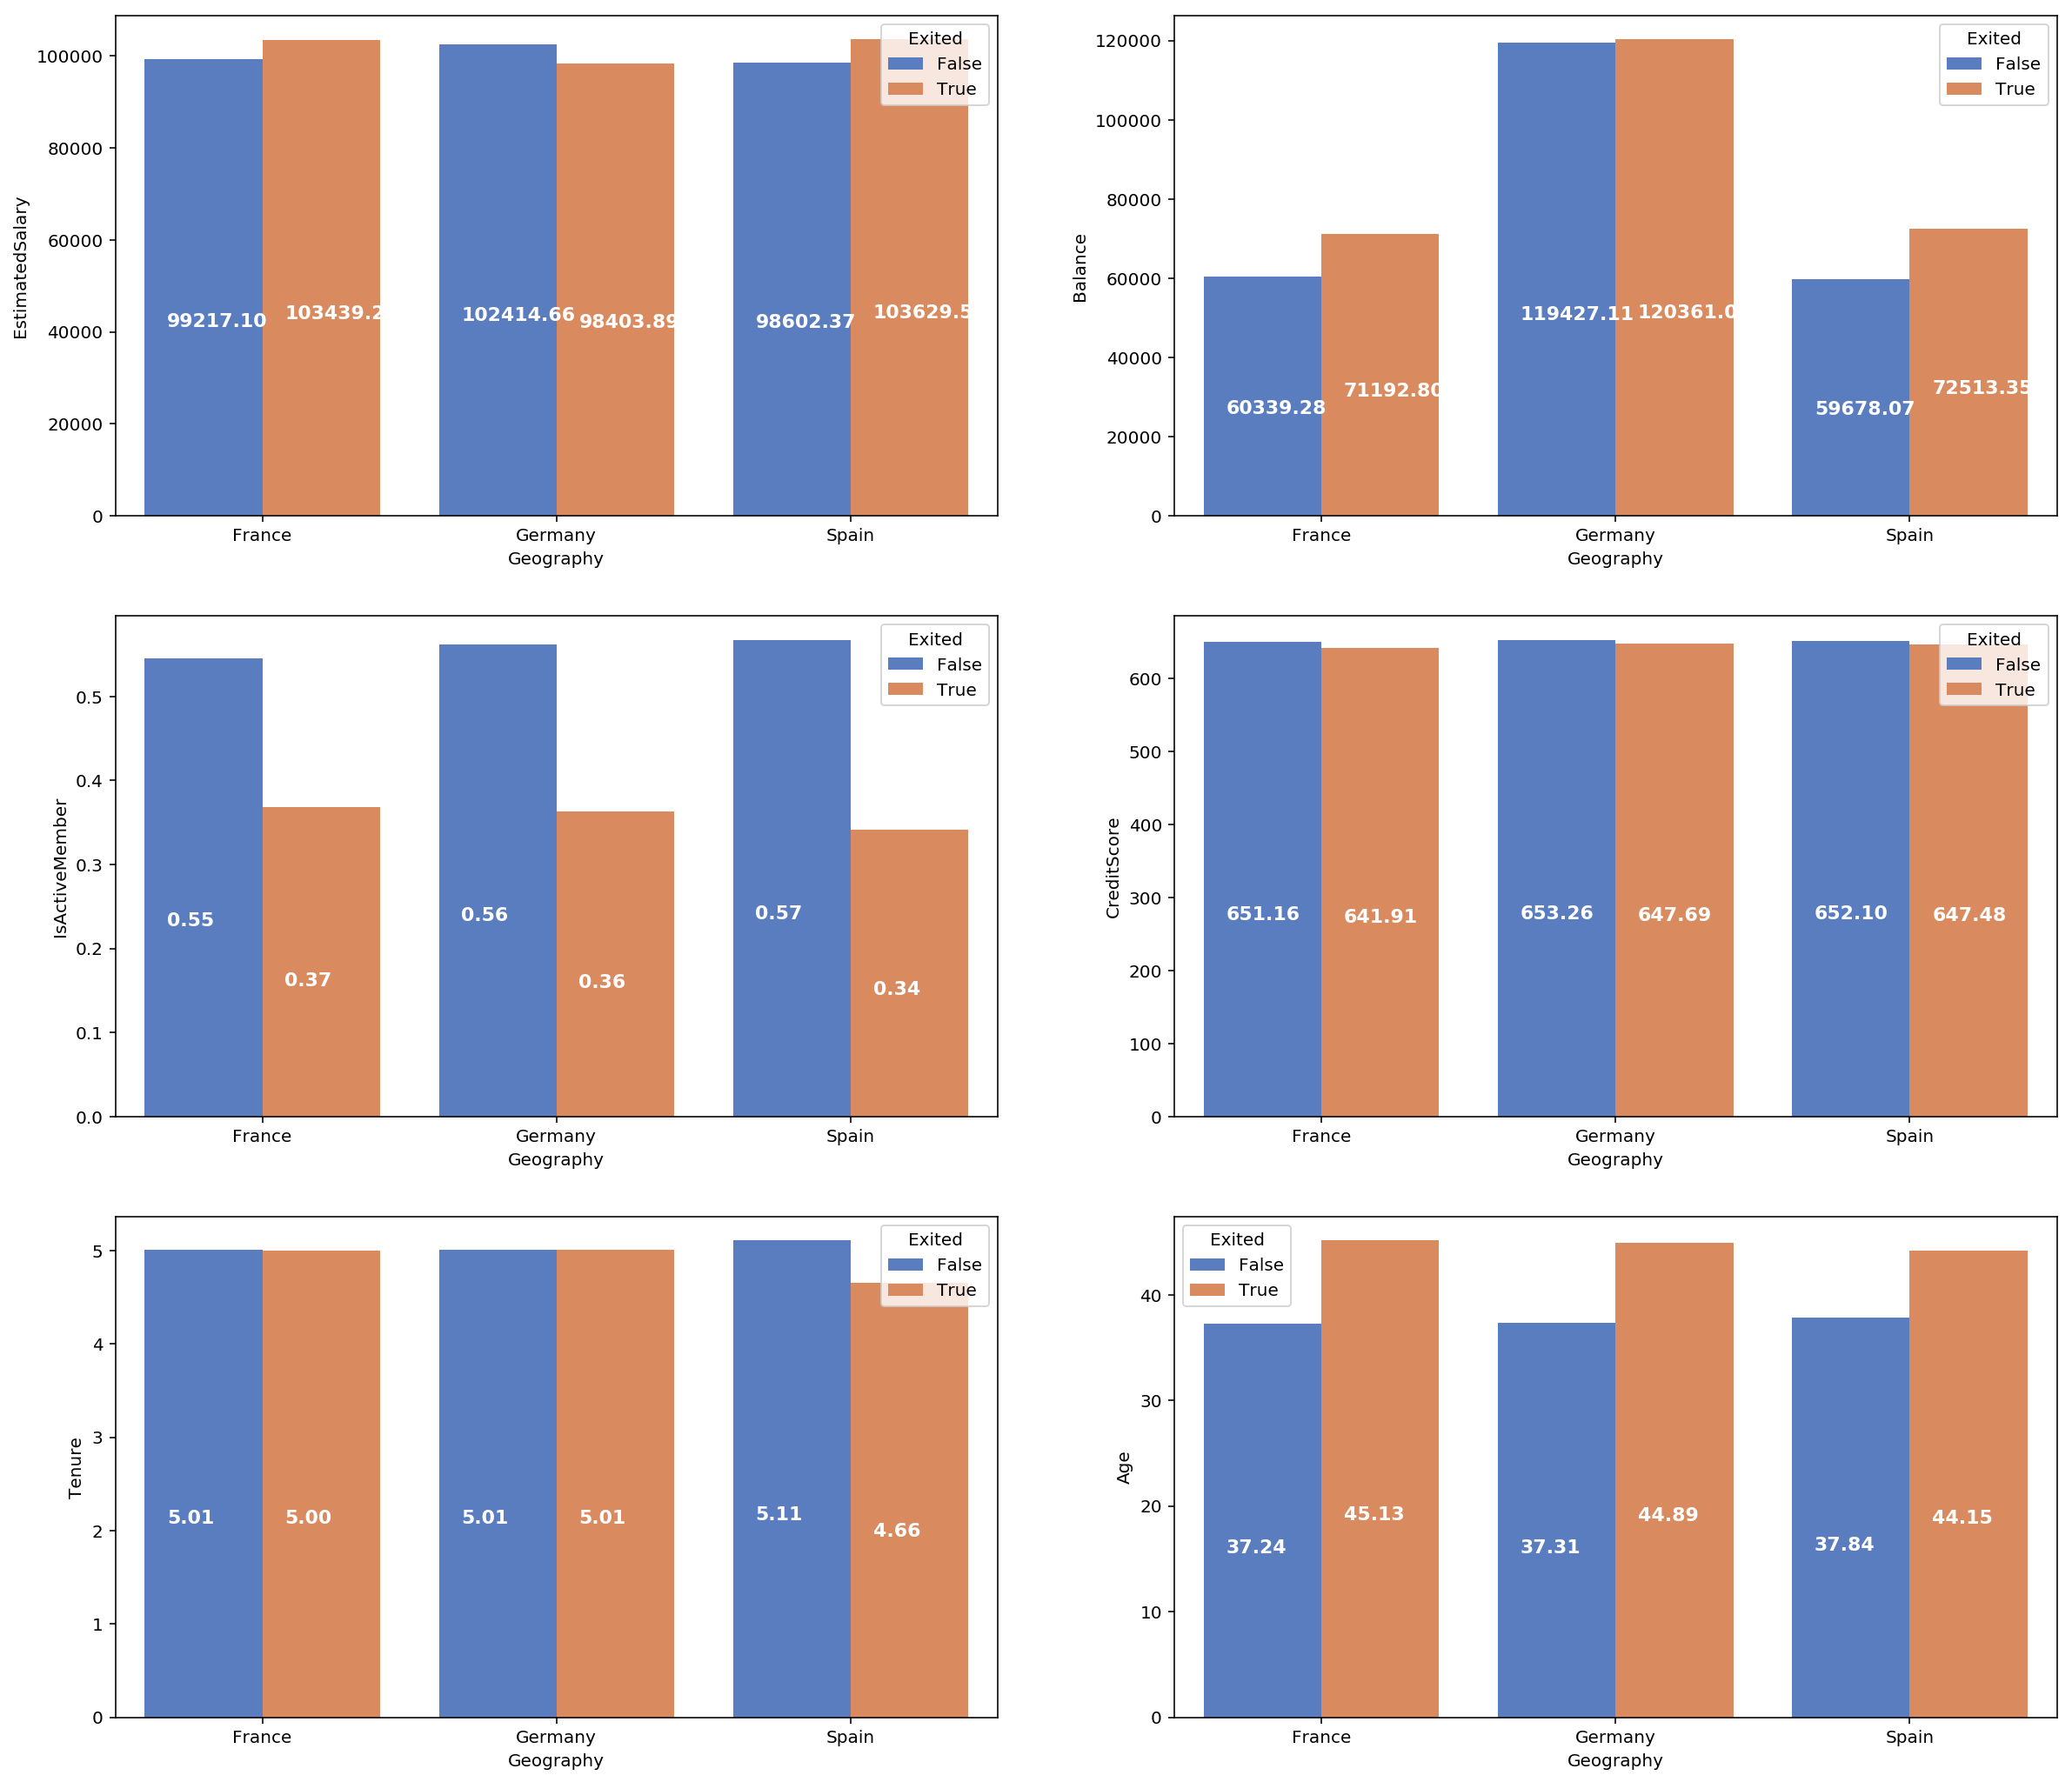

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

#Main graphs
for col, ax in zip(['EstimatedSalary', 'Balance', 'IsActiveMember', 'CreditScore', 'Tenure', 'Age'], axes.flatten()):
    sns.barplot(x='Geography', y=col, hue='Exited', data=df, ax=ax, palette="muted", ci=None)
    #legend=ax.legend(['Churned','Non-Churned'],
                     #, loc='best')

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.2f}'.format(height), (p.get_x()+.19*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold', fontsize=11)
 


# <a id='4'>4. Data Processing</a>

## <a id='4.1'>4.1. Encoding Categorical, binary and standardizing numerical variables </a>


#### Label Encode Dummy Variables

In [20]:
dummy_cols   = ['HasCrCard', 'IsActiveMember', 'Gender']

#Label encoding Binary columns
for i in dummy_cols :
    df[i] = LabelEncoder().fit_transform(df[i])

#### Standardize numerical variables

In [21]:
num_cols = ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary']

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_2 = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

#### Get dummy variables from Categorical

In [22]:
categorical_vars = ['NumOfProducts', 'Geography', 'Age_cat']
df= pd.get_dummies(data = df, columns= categorical_vars )

In [23]:
feature  = ['Gender', 'HasCrCard', 'IsActiveMember', 'Geography_Germany',
 'Geography_Spain', 'Age_cat_18-24', 'Age_cat_25-34', 'Age_cat_35-44', 'Age_cat_45-54', 'Age_cat_55-65',
       'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3', 'CreditScore', 
      'Tenure', 'Balance', 'EstimatedSalary']
y = df['Exited']
X = df[feature]

#### Correlation Plot Matrix

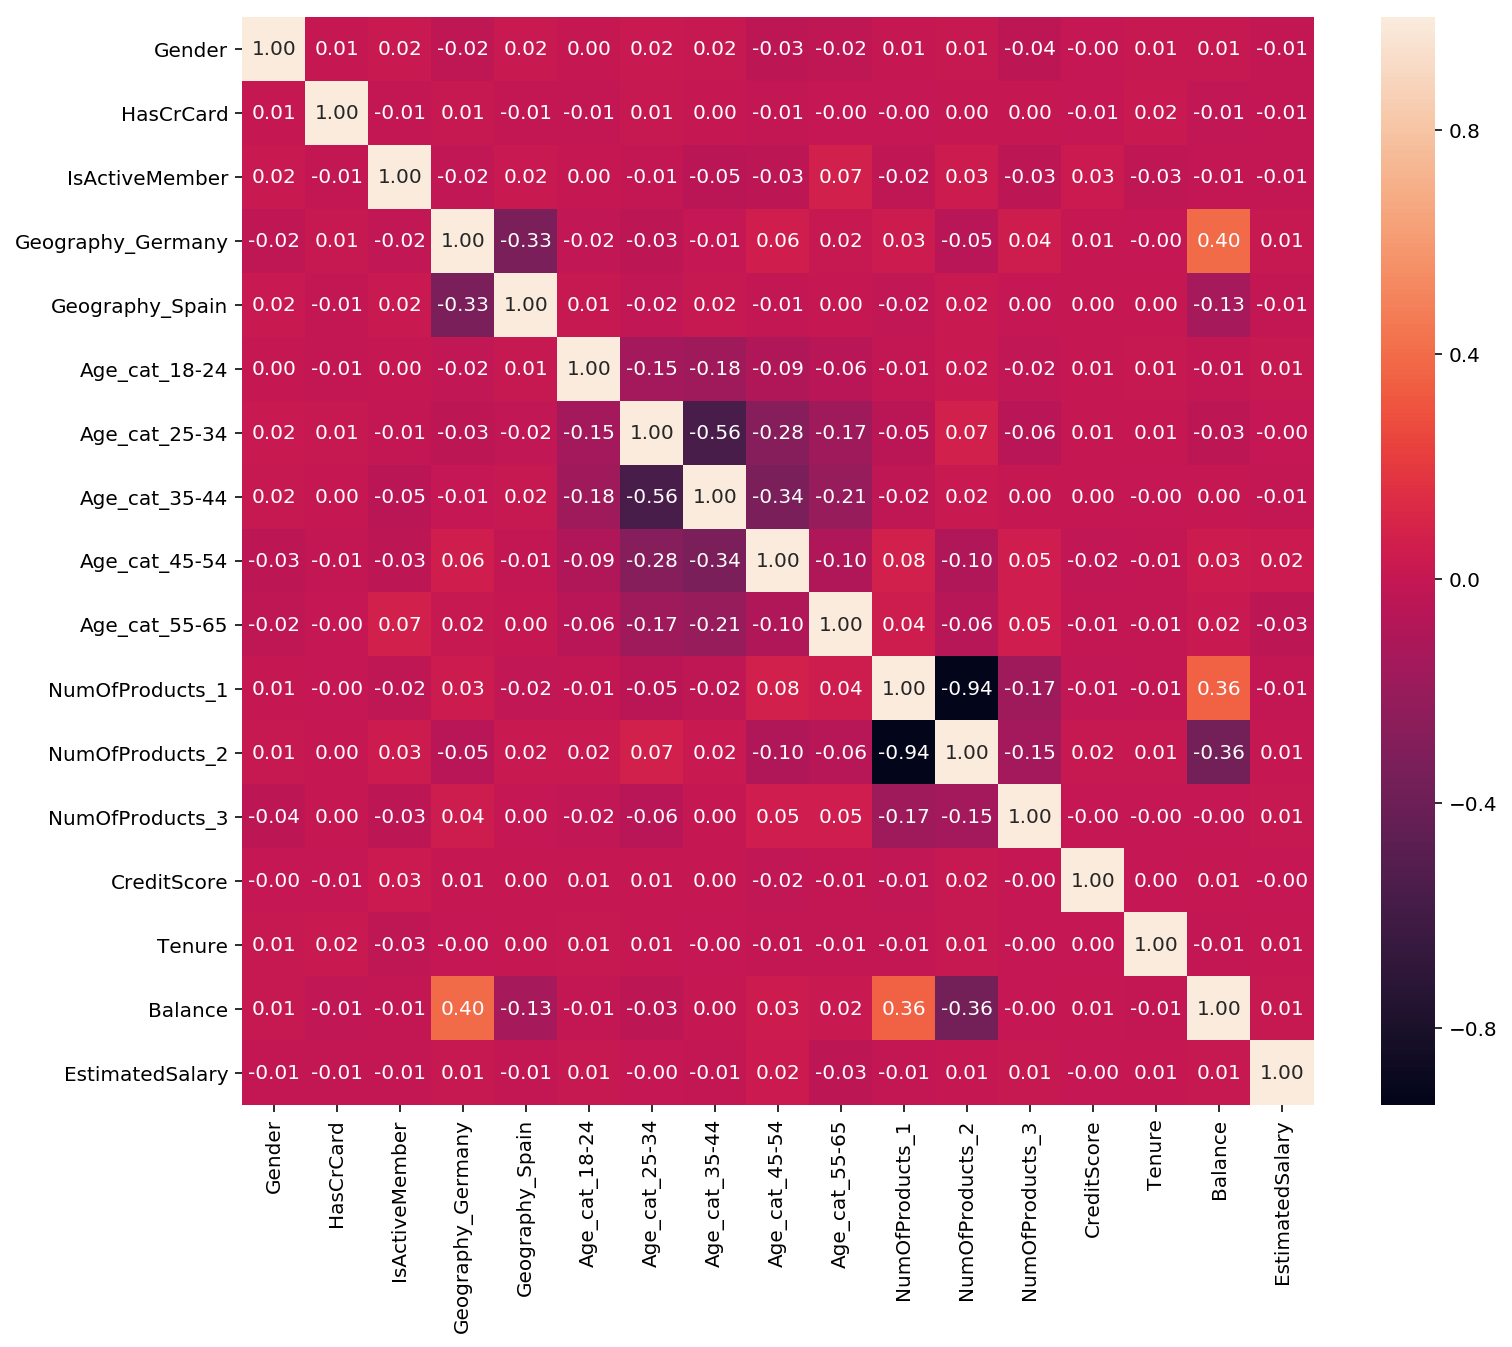

In [24]:
#Size of the figure
plt.rcParams["figure.figsize"]=12,10 #(width, height)


#A quick correlation plot
sns.heatmap(X.corr(), annot=True, fmt=".2f")
plt.show()

## <a id='4.2'>4.2. Imbalanced dataset - resampling the target outcome </a>


-  An imbalanced datasets is a classic problem of unbalanced classes, since customer churning is on average considered an  unusual cases when taking into consideration all clients on the platform.
-  In this dataset we generally find that customers tend to stay with the bank and we onl observe a +/-20% churn rate

In [25]:
target_count =y.value_counts()
print('False:', target_count[0])
print('True:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

False: 7963
True: 2037
Proportion: 3.91 : 1


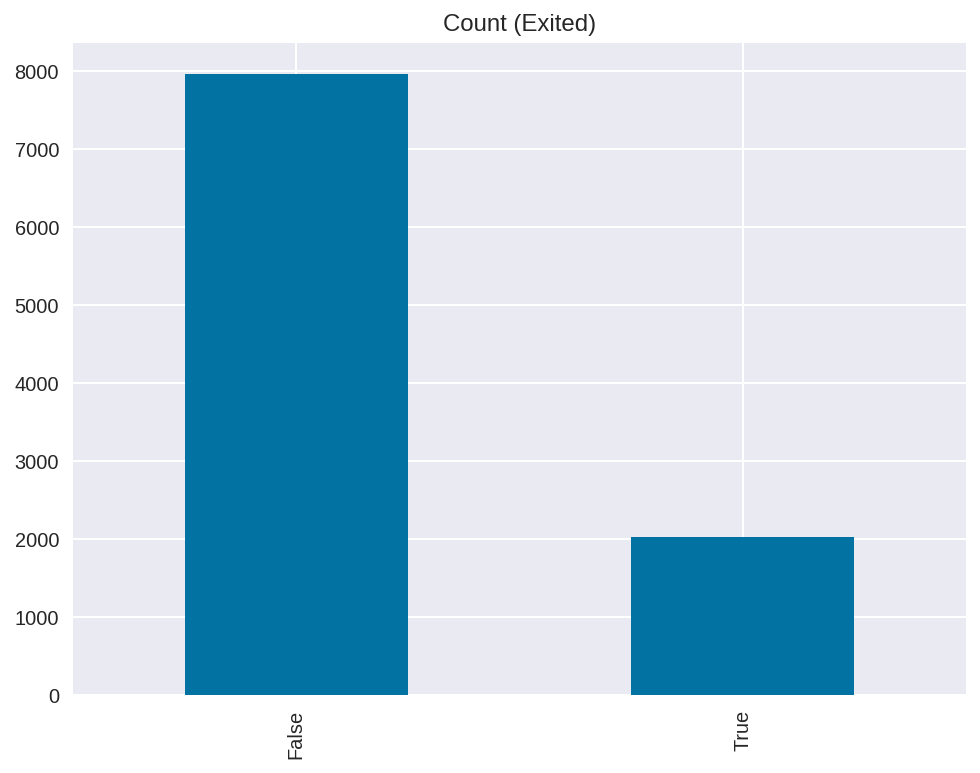

In [33]:
#Setting the style
plt.style.use('seaborn-darkgrid')

#Size of the figure
plt.rcParams["figure.figsize"]=8,6
target_count.plot(kind='bar', title='Count (Exited)')
plt.show()

#### We can use a resampling method to correct the imbalance and in this instance we use the Tomek links method

In [27]:
import imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)
X = X_sm
y = y_sm

True     7963
False    7963
dtype: int64

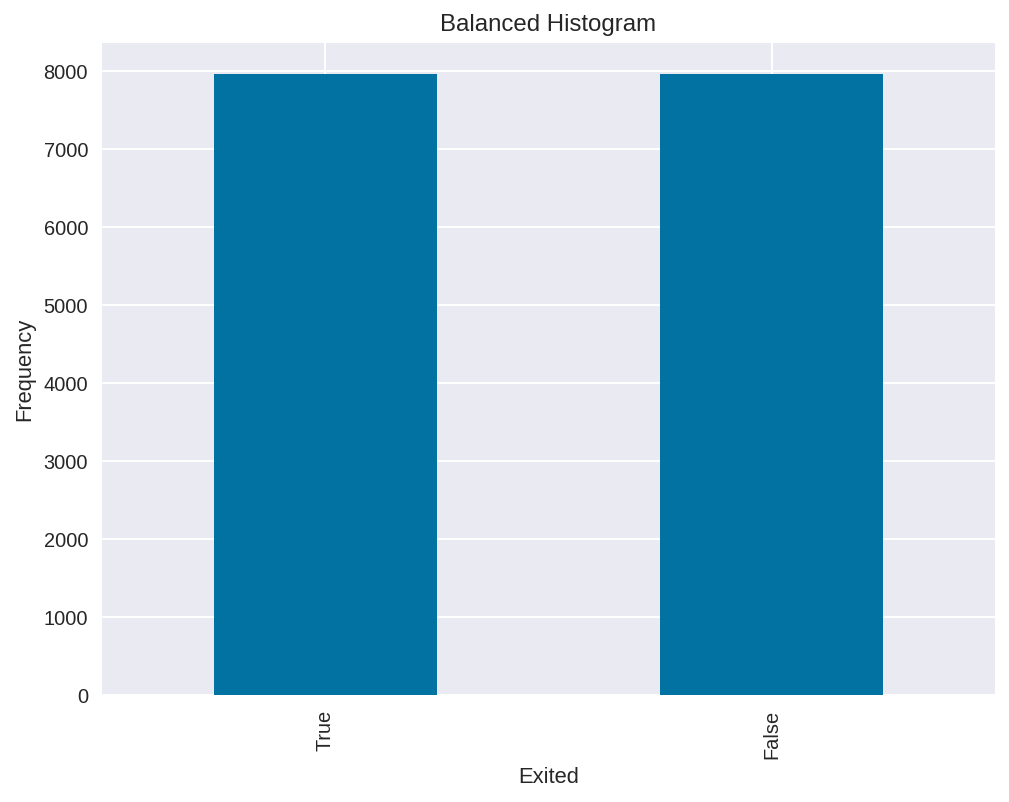

In [44]:
#Setting the style
plt.style.use('seaborn-darkgrid')

#Size of the figure
plt.rcParams["figure.figsize"]=8,6
pd.value_counts(y).plot.bar()
plt.title('Balanced Histogram')
plt.xlabel('Exited')
plt.ylabel('Frequency')
pd.value_counts(y)

# <a id='5'>5. Data Modelling</a>

#### Visualization: Confusion matrices and AUC curves

In [32]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

## <a id='5.1'>5.1.  Logistic Regression Model (Baseline mode)</a>

In [29]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [30]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 

log_model = LogisticRegression()

log_model.fit(X_train,y_train)
print(log_model.score(X_test,y_test))

y_pred = log_model.predict(X_test)

cross_val_score(log_model,X,y,cv=10).mean()


0.7674535409342039
CPU times: user 2.52 s, sys: 4.01 s, total: 6.53 s
Wall time: 1.28 s


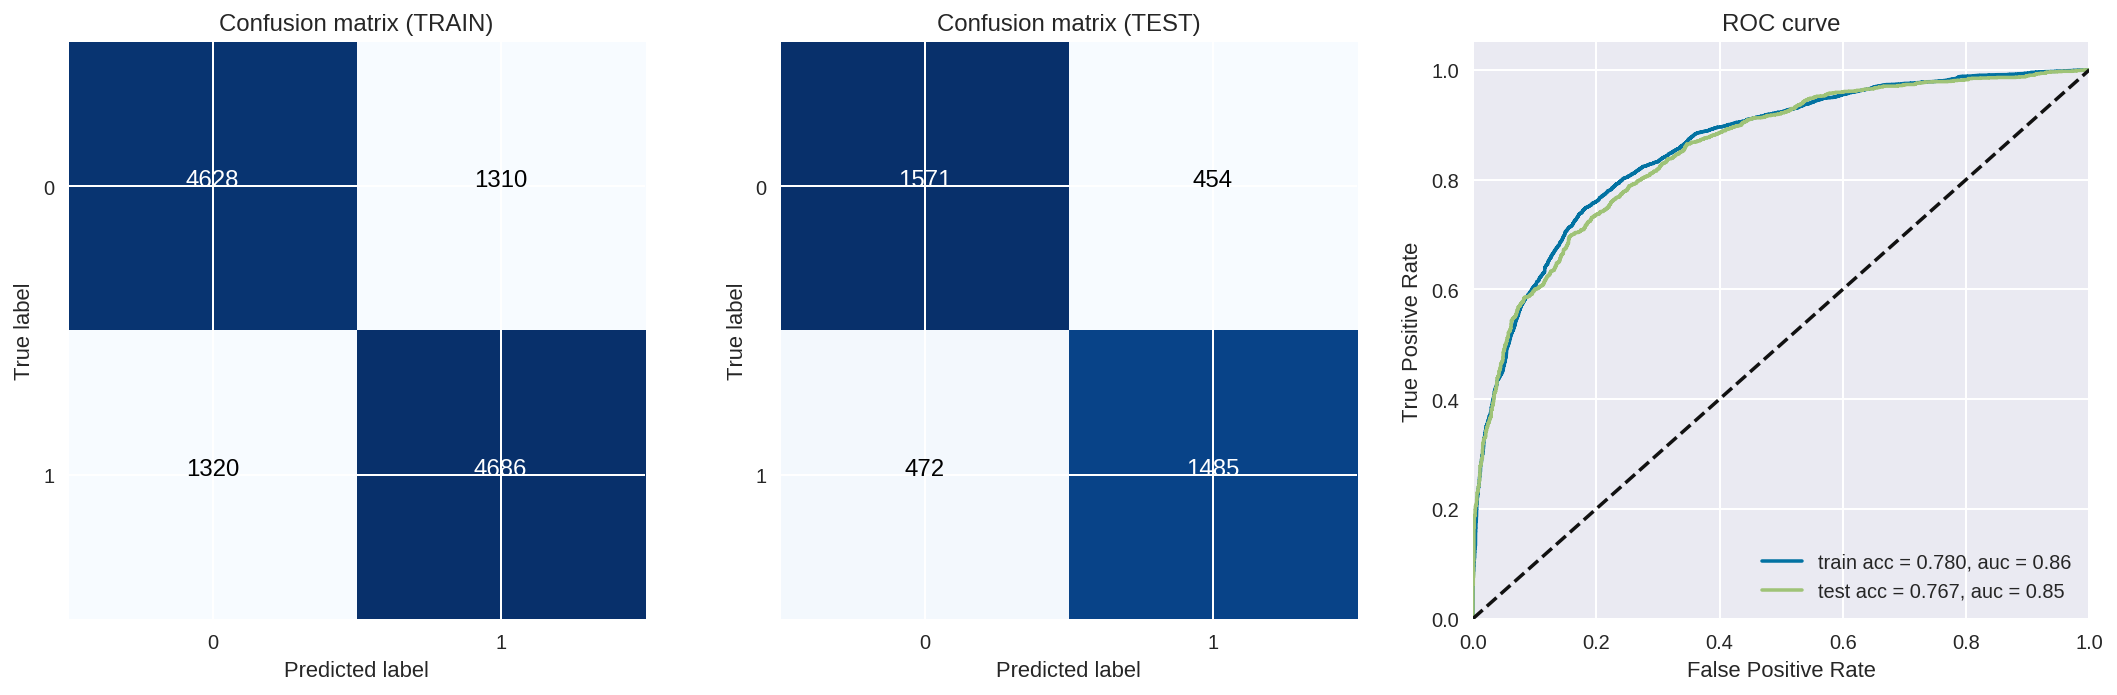

In [35]:
#Setting the style
plt.style.use('seaborn-darkgrid')
y_train_pred = log_model.predict_proba(X_train)[:,1]
y_test_pred = log_model.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### Feature Importance

In [45]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 

from yellowbrick.features.importances import FeatureImportances

#Setting the style
plt.style.use('seaborn-darkgrid')


#Size of the figure
plt.rcParams["figure.figsize"]=9,7 #(width, height)

# Create a new figure
fig = plt.figure()
ax = fig.add_subplot()

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), X))
viz = FeatureImportances(LinearRegression(), ax=ax, labels=labels, relative=False)

# Fit and show the feature importances
viz.fit(X, y)

viz.poof()

AttributeError: 'numpy.ndarray' object has no attribute 'title'

<Figure size 648x504 with 0 Axes>

## <a id='5.2'>5.2.  Random Forest Model</a>

In [37]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
rf.fit(X_train,y_train)

CPU times: user 1.13 s, sys: 0 ns, total: 1.13 s
Wall time: 1.14 s


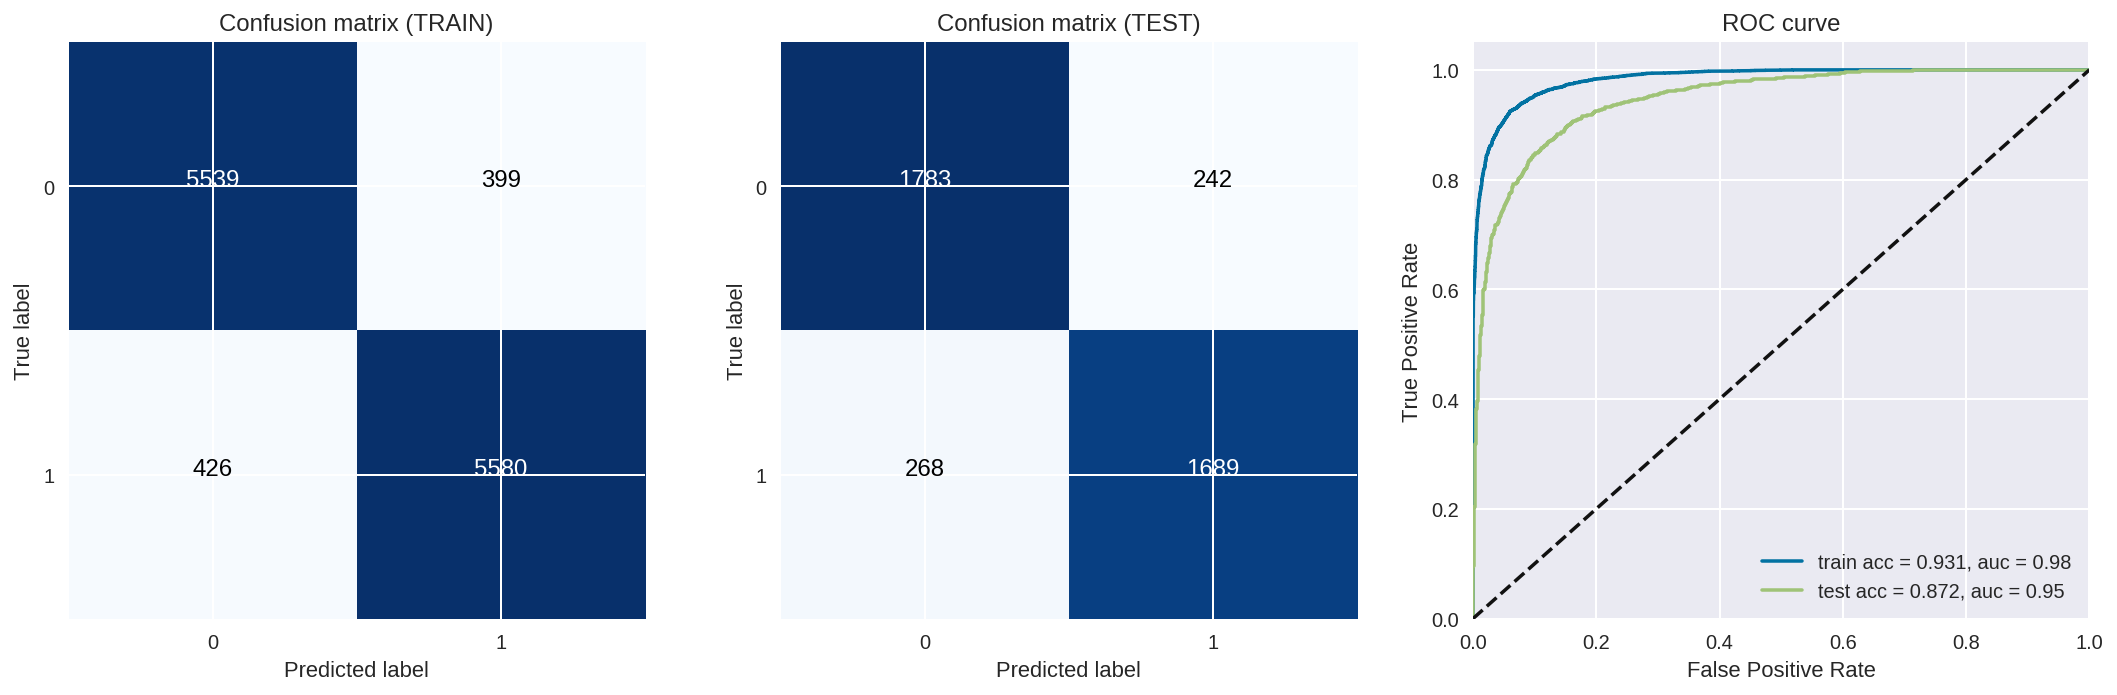

In [40]:

from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()